In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from imageio import imread
import numpy as np
import os
from os.path import join
import train_interactions
import pandas as pd
import train_interactions
import warnings
pd.set_option('precision', 2)

In [8]:
DATA_DIR = '/home/matej/prace/ferda/data/interactions/1712_1k_36rot'
EXPERIMENT_DIR = '/home/matej/prace/ferda/experiments/171216_0308/'
# SUB_EXPERIMENT = 0.620689655172

In [24]:
def tostruct(ndarray):
    NAMES = 'ant1_x, ant1_y, ant1_major, ant1_minor, ant1_angle_deg, ant1_dx, ant1_dy,' \
            'ant2_x, ant2_y, ant2_major, ant2_minor, ant2_angle_deg, ant2_dx, ant2_dy'
    FORMATS = 14 * 'f,'
    return np.core.records.fromarrays(ndarray.transpose(), names=NAMES, formats=FORMATS)

In [25]:
y_test = pd.read_csv(join(DATA_DIR, 'test.csv'))    

with h5py.File(join(EXPERIMENT_DIR, 'predictions.h5'), 'r') as hf:  # str(SUB_EXPERIMENT), 
    pred = hf['data'][:]
    pred_df = pd.DataFrame(tostruct(pred))
    
loss_alpha_batch = pd.read_csv(join(EXPERIMENT_DIR, 'results.csv'))    

In [17]:
# loss_alpha_batch[loss_alpha_batch['loss_alpha'] == SUB_EXPERIMENT]

In [ ]:
loss_alpha_batch['xy MAE'].iloc[-1] = np.nan
xy = loss_alpha_batch['xy MAE']
loss_alpha_batch['xy MAE norm'] = (xy - xy.mean()) / xy.std()
#loss_alpha_batch['angle MAE'].iloc[0] = np.nan
angle = loss_alpha_batch['angle MAE']
loss_alpha_batch['angle MAE norm'] = (angle - angle.mean()) / angle.std()
loss_alpha_batch['sum norm'] = loss_alpha_batch['angle MAE norm'] + loss_alpha_batch['xy MAE norm']
loss_alpha_batch['alpha sum norm'] = loss_alpha_batch['angle MAE norm'] * (1 - loss_alpha_batch['loss_alpha']) + \
                                     loss_alpha_batch['xy MAE norm'] * loss_alpha_batch['loss_alpha']

In [ ]:
# ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE norm', 'angle MAE norm', 'alpha sum norm'], 
#                            title='normalized mean absolute errors')
# ax.legend(['xy', 'angle', 'alpha weighted sum'])
# ax.set_xlabel('alpha')

In [ ]:
ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE', 'angle MAE'], title='mean absolute errors')
ax.set_ylabel('deg, px')
ax.set_xlabel('alpha')
ax.set_ylim(0, 24)
ax.vlines(SUB_EXPERIMENT, ax.get_ylim()[0], ax.get_ylim()[1],
          'r')
ax.legend(['xy', 'angle', 'best alpha'])

# Predictions

In [26]:
pred_df.describe()

,ant1_x,ant1_y,ant1_major,ant1_minor,ant1_angle_deg,ant1_dx,ant1_dy,ant2_x,ant2_y,ant2_major,ant2_minor,ant2_angle_deg,ant2_dx,ant2_dy
count,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00
mean,92.78,107.19,-11.36,-21.49,11.91,0.97,15.04,104.87,89.26,-0.01,12.95,72.04,-1.70,8.33
std,9.66,7.75,10.33,6.22,6.57,7.87,10.70,10.85,7.06,7.84,8.59,8.26,9.31,7.94
min,67.47,83.80,-31.40,-50.21,-16.64,-35.44,-9.39,72.06,71.45,-29.56,-7.95,40.22,-39.41,-41.54
25%,85.16,102.40,-19.26,-24.79,8.17,-3.28,7.08,96.89,83.71,-6.18,6.18,66.68,-6.03,4.32
50%,92.30,108.74,-12.92,-19.77,12.33,3.58,13.09,105.71,88.10,-0.16,11.68,70.27,0.60,9.39
75%,100.27,112.71,-4.50,-17.13,16.46,6.77,21.85,113.57,94.57,6.03,19.02,75.80,4.41,13.19
max,123.28,126.65,26.49,-8.75,28.01,16.77,64.39,135.17,119.95,25.41,45.99,112.72,23.52,29.41


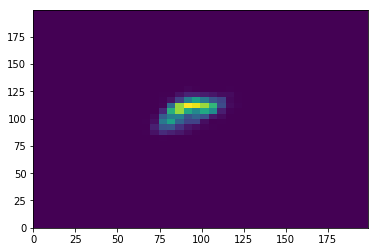

In [27]:
_ = plt.hist2d(pred_df['ant1_x'], pred_df['ant1_y'], bins=40, range=((0, 199), (0, 199)))

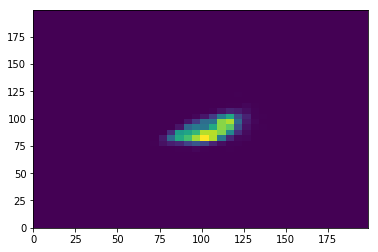

In [28]:
_ = plt.hist2d(pred_df['ant2_x'], pred_df['ant2_y'], bins=40, range=((0, 199), (0, 199)))

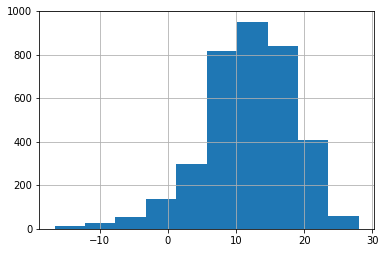

In [29]:
pred_df['ant1_angle_deg'].hist()

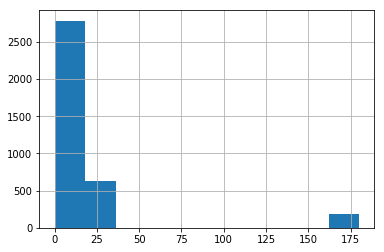

In [30]:
(pred_df['ant1_angle_deg'] % 180).hist()

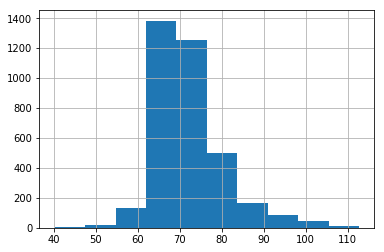

In [32]:
pred_df['ant2_angle_deg'].hist()

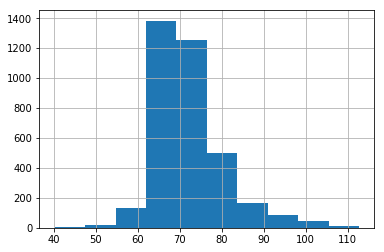

In [31]:
(pred_df['ant2_angle_deg'] % 180).hist()

# Prediction Errors

In [35]:
OBJ_IDS_STR = ['1', '2']
OBJ_IDS = (0, 1)

COLUMNS_MAP = [('x', 'ant%s_x'),
       ('y', 'ant%s_y'),
       ('major', 'ant%s_major'),
       ('minor', 'ant%s_minor'),
       ('angle_deg', 'ant%s_angle_deg'),
       ('dx', 'ant%s_dx'),
       ('dy', 'ant%s_dy'),
       ]

COL = dict(COLUMNS_MAP)
NAMES = reduce(list.__add__, [[value % i for key, value in COLUMNS_MAP] for i in OBJ_IDS_STR])
COL2ID = {key: i for i, (key, value) in enumerate(COLUMNS_MAP)}
NAME2COL = {num: {key: i + (j * len(COLUMNS_MAP)) for i, (key, value) in enumerate(COLUMNS_MAP)}
            for j, num in enumerate(OBJ_IDS)}
NAME2COL_ = {num: {key: slice(i + (j * len(COLUMNS_MAP)),
                              i + (j * len(COLUMNS_MAP)) + 1)
                   for i, (key, value) in enumerate(COLUMNS_MAP)}
             for j, num in enumerate(OBJ_IDS)}

NUM_PARAMS = len(COLUMNS_MAP) * len(OBJ_IDS)

In [53]:
for i in ['1', '2']:
    y_test[COL['angle_deg'] % i] *= -1  # convert to anti-clockwise
    angle_rad = np.radians(y_test[COL['angle_deg'] % i])
    y_test[COL['dx'] % i] = y_test[COL['major'] % i] * np.cos(angle_rad)
    y_test[COL['dy'] % i] = y_test[COL['major'] % i] * np.sin(angle_rad)


(3600, 14)

In [57]:
y_test = y_test[NAMES]

In [54]:
xy, _, indices = train_interactions.match_pred_to_gt(pred, y_test[NAMES].values, np)

xy_mae = (xy[indices[:, 0], indices[:, 1]]).mean()

In [59]:
# compute angle errors
angle = {}
for i, j in ((0, 0), (1, 1), (0, 1), (1, 0)):
    angle[(i, j)] = train_interactions.angle_absolute_error(
        y_test.values[:, NAME2COL[i]['angle_deg']],
        np.degrees(np.arctan((pred[:, NAME2COL[j]['dy']] / pred[:, NAME2COL[j]['dx']]))),
        np)
mean_errors_angle = np.stack((
    np.mean(np.stack((angle[0, 0], angle[1, 1]), axis=1), axis=1),
    np.mean(np.stack((angle[0, 1], angle[1, 0]), axis=1), axis=1)))  # shape=(2, n)
angle_mae = (mean_errors_angle[indices[:, 0], indices[:, 1]]).mean()

In [68]:
i, j = 0, 0
y_test.values[:, NAME2COL[i]['angle_deg']] % 180

array([ 26.2,   5.4,  66.8, ...,  35. ,  20.9,  66.5])

In [69]:
 np.degrees(np.arctan((pred[:, NAME2COL[j]['dy']] / pred[:, NAME2COL[j]['dx']])))

array([-29.01,  62.88,  75.89, ..., -37.96,  70.38,  57.05], dtype=float32)

In [33]:
xy, angle, indices = train_interactions.match_pred_to_gt(pred, y_test[train_interactions.NAMES].values, np)
xy_errors = (xy[indices[:, 0], indices[:, 1]])
angle_errors = (angle[indices[:, 0], indices[:, 1]])

# swap = indices[:, 0] == 1
# pred_swapped = pred.copy()
# pred_swapped[swap, :5], pred_swapped[swap, 5:] = pred_swapped[swap, 5:], pred_swapped[swap, :5]

KeyError: "['ant1_dx' 'ant1_dy' 'ant2_dx' 'ant2_dy'] not in index"

In [ ]:
df = pd.DataFrame.from_items([('xy (px)', [xy_errors.mean()]), 
                              ('angle (deg)', angle_errors.mean()),])
df.style.set_caption('MAE')
df

In [ ]:
_  = plt.hist(xy_errors)

In [ ]:
_ = plt.hist(angle_errors)

# Model

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = train_interactions.model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# SVG(model_to_dot(model.get_layer('model_1'), show_shapes=True).create(prog='dot', format='svg'))